# install

In [1]:
!pip -q install ultralytics timm tqdm pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00


# import & setup

In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# path

In [3]:

BASE  = Path("/kaggle/input/assignment-mango/mango")
WORK  = Path("/kaggle/working/mango_ssl_yolov10_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_mango.yaml"
SSL_W = WORK / "backbone_ssl_v10_dinov2.pt"   # <-- conv backbone weights only
WORK.mkdir(parents=True, exist_ok=True)


# Split & coco to yolo

In [4]:
import json
import yaml
import shutil
import numpy as np
from pathlib import Path
from collections import defaultdict

# Define your paths here - ADJUST THESE TO MATCH YOUR STRUCTURE
BASE = Path("/kaggle/input/assignment-mango/mango")  # Path to your mango dataset
SPLIT = Path("/kaggle/working/yolo_split")  # Where to save YOLO format
DATA = SPLIT / "data.yaml"  # YAML config file

def coco2yolo(b, w, h):
    """Convert COCO bbox format to YOLO format"""
    x, y, bw, bh = b
    return (x + bw/2)/w, (y + bh/2)/h, bw/w, bh/h

def convert_mango_dataset():
    """Convert your mango COCO dataset to YOLO format with train/val/test splits"""

    # Define the annotation folders and their corresponding image folders
    annotation_folders = {
        'Early-fruit': BASE / "Annotation" / "Early-fruit" / "_annotations.coco.json",
        'Mature': BASE / "Annotation" / "Mature" / "_annotations.coco.json",
        'Ripe': BASE / "Annotation" / "Ripe" / "_annotations.coco.json"
        # Note: Premature folder doesn't have _annotations.coco.json according to your structure
    }

    # Image folders
    image_folders = {
        'Early-Fruit_COCO': BASE / "Early-Fruit_COCO",
        'Mature_COCO': BASE / "Mature_COCO",
        'Premature_COCO': BASE / "Premature_COCO",
        'Ripe_COCO': BASE / "Ripe_COCO"
    }

    # Create output directories
    train_images = SPLIT / "train" / "images"
    train_labels = SPLIT / "train" / "labels"
    val_images = SPLIT / "valid" / "images"
    val_labels = SPLIT / "valid" / "labels"
    test_images = SPLIT / "test" / "images"
    test_labels = SPLIT / "test" / "labels"

    for dir_path in [train_images, train_labels, val_images, val_labels, test_images, test_labels]:
        dir_path.mkdir(parents=True, exist_ok=True)

    all_images = []
    all_annotations = {}
    class_names = set()

    print("➤ Processing annotation files...")

    # Process each annotation file
    for stage, ann_file in annotation_folders.items():
        if ann_file.exists():
            print(f"  • Processing {stage} annotations...")
            try:
                with open(ann_file, 'r') as f:
                    coco_data = json.load(f)

                # Collect class names
                for cat in coco_data['categories']:
                    class_names.add(cat['name'])

                # Create image ID to image info mapping
                id2img = {img['id']: img for img in coco_data['images']}

                # Process annotations
                for ann in coco_data['annotations']:
                    img_id = ann['image_id']
                    if img_id in id2img:
                        img_info = id2img[img_id]
                        img_filename = img_info['file_name']

                        # Convert bbox to YOLO format
                        yolo_bbox = coco2yolo(ann['bbox'], img_info['width'], img_info['height'])

                        # Store annotation
                        if img_filename not in all_annotations:
                            all_annotations[img_filename] = []
                        all_annotations[img_filename].append({
                            'class_id': ann['category_id'] - 1,  # YOLO uses 0-based indexing
                            'bbox': yolo_bbox
                        })

                # Collect image files from this stage
                for img in coco_data['images']:
                    all_images.append({
                        'filename': img['file_name'],
                        'stage': stage,
                        'width': img['width'],
                        'height': img['height']
                    })

            except Exception as e:
                print(f"⚠ Error processing {stage}: {e}")
        else:
            print(f"⚠️ Annotation file not found: {ann_file}")

    # Also collect images from folders without annotations (like Premature)
    print("  • Collecting images from image folders...")
    for folder_name, img_folder in image_folders.items():
        if img_folder.exists():
            stage = folder_name.replace('_COCO', '').replace('-', '_')  # Normalize stage name
            for img_file in img_folder.glob('*.jpg'):
                # Check if already processed from annotations
                already_exists = any(img['filename'] == img_file.name for img in all_images)
                if not already_exists:
                    all_images.append({
                        'filename': img_file.name,
                        'stage': stage,
                        'source_folder': img_folder,
                        'width': None,
                        'height': None
                    })

    print(f"  • Found {len(all_images)} total images")
    print(f"  • Found {len(all_annotations)} images with annotations")

    # Create train/val/test split (80/10/10)
    np.random.seed(42)
    np.random.shuffle(all_images)

    n_total = len(all_images)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)

    train_imgs = all_images[:n_train]
    val_imgs = all_images[n_train:n_train+n_val]
    test_imgs = all_images[n_train+n_val:]

    print(f"➤ Creating splits:")
    print(f"  • Train: {len(train_imgs)} images")
    print(f"  • Validation: {len(val_imgs)} images")
    print(f"  • Test: {len(test_imgs)} images")

    # Function to copy images and labels for a split
    def copy_split(images, split_name, img_dir, label_dir):
        copied_count = 0
        for img_info in images:
            filename = img_info['filename']
            stage = img_info['stage']

            # Find source image file
            source_img = None
            for folder_name, img_folder in image_folders.items():
                potential_path = img_folder / filename
                if potential_path.exists():
                    source_img = potential_path
                    break

            if source_img and source_img.exists():
                # Copy image
                shutil.copy(source_img, img_dir / filename)

                # Create label file if annotations exist
                if filename in all_annotations:
                    label_filename = f"{Path(filename).stem}.txt"
                    with open(label_dir / label_filename, 'w') as f:
                        for ann in all_annotations[filename]:
                            bbox_str = ' '.join([f"{x:.6f}" for x in ann['bbox']])
                            f.write(f"{ann['class_id']} {bbox_str}\n")

                copied_count += 1
            else:
                print(f"⚠️ Image not found: {filename}")

        print(f"   ✓ Copied {copied_count} images for {split_name}")
        return copied_count

    # Copy files for each split
    copy_split(train_imgs, "train", train_images, train_labels)
    copy_split(val_imgs, "validation", val_images, val_labels)
    copy_split(test_imgs, "test", test_images, test_labels)

    # Create class names list
    class_names_list = sorted(list(class_names)) if class_names else ['mango']

    return class_names_list

# Main conversion logic - SIMPLIFIED (no SSL split)
if not DATA.exists():
    print("➤ Converting Mango COCO → YOLO …")
    class_names = convert_mango_dataset()

    # Create YAML config
    config = {
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(class_names),
        "names": class_names
    }

    DATA.write_text(yaml.dump(config))
    print("✓ YOLO split ready.")

else:
    print("YOLO split already exists")


➤ Converting Mango COCO → YOLO …
➤ Processing annotation files...
  • Processing Early-fruit annotations...
  • Processing Mature annotations...
  • Processing Ripe annotations...
  • Collecting images from image folders...
  • Found 2004 total images
  • Found 1476 images with annotations
➤ Creating splits:
  • Train: 1603 images
  • Validation: 200 images
  • Test: 201 images
   ✓ Copied 1603 images for train
   ✓ Copied 200 images for validation
   ✓ Copied 201 images for test
✓ YOLO split ready.


# Multi-mango dataset (DINOv2-style: 2 global + 8 local)

In [5]:
class MultiMangoDino(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        mangos = [self.g1(img), self.g2(img)]  # 2 global crops
        mangos.extend([self.local(img) for _ in range(self.n_local)])  # 8 local crops
        return mangos  # Return the list of augmented mango crops


# Build YOLOv10s model and grab backbone (no fallback)

In [6]:
#    Robust encoder that handles different backbone return types/shapes


detector = YOLO("yolov10n.yaml")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolov10n.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)


Backbone feature dim: 16


# DINOv2-style projector heads + loss

In [7]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


#  DINOv2-style SSL pretraining

In [8]:
EPOCHS     = 50      # increase to 50—100 for stronger transfer
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.990
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("✓ SSL backbone cache found — skipping DINOv2-style pretrain")
else:
    print("\n🔥 DINOv2-style pretraining on YOLOv10 backbone …")
    ds = MultiMangoDino([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for mangos in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            mangos = [v.to(device) for v in mangos]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in mangos]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in mangos[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv10 backbone →", SSL_W)



🔥 DINOv2-style pretraining on YOLOv10 backbone …


/tmp/ipykernel_19/1582774729.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 01: loss=4.9455


SSL Ep 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 02: loss=3.1813


SSL Ep 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 03: loss=2.7415


SSL Ep 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 04: loss=2.6870


SSL Ep 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 05: loss=3.0054


SSL Ep 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 06: loss=3.3712


SSL Ep 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 07: loss=4.5235


SSL Ep 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 08: loss=4.2178


SSL Ep 9/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 09: loss=3.9957


SSL Ep 10/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 10: loss=3.7982


SSL Ep 11/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 11: loss=3.8223


SSL Ep 12/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 12: loss=4.0739


SSL Ep 13/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 13: loss=4.2770


SSL Ep 14/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.2002


SSL Ep 15/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.0209


SSL Ep 16/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 16: loss=3.6882


SSL Ep 17/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 17: loss=3.7953


SSL Ep 18/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 18: loss=3.3824


SSL Ep 19/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 19: loss=3.2841


SSL Ep 20/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 20: loss=3.5744


SSL Ep 21/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 21: loss=3.8020


SSL Ep 22/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 22: loss=3.7959


SSL Ep 23/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 23: loss=3.7131


SSL Ep 24/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 24: loss=3.6807


SSL Ep 25/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 25: loss=3.5255


SSL Ep 26/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 26: loss=3.4498


SSL Ep 27/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 27: loss=3.5293


SSL Ep 28/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 28: loss=3.2721


SSL Ep 29/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 29: loss=3.2866


SSL Ep 30/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 30: loss=3.3280


SSL Ep 31/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 31: loss=3.4606


SSL Ep 32/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 32: loss=3.5348


SSL Ep 33/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 33: loss=3.6884


SSL Ep 34/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 34: loss=3.7116


SSL Ep 35/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 35: loss=3.6302


SSL Ep 36/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 36: loss=3.6690


SSL Ep 37/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 37: loss=3.6503


SSL Ep 38/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 38: loss=3.6311


SSL Ep 39/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 39: loss=3.6617


SSL Ep 40/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 40: loss=3.6632


SSL Ep 41/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 41: loss=3.6512


SSL Ep 42/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 42: loss=3.6624


SSL Ep 43/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 43: loss=3.6003


SSL Ep 44/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 44: loss=3.5883


SSL Ep 45/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 45: loss=3.6308


SSL Ep 46/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 46: loss=3.5820


SSL Ep 47/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 47: loss=3.5728


SSL Ep 48/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 48: loss=3.5282


SSL Ep 49/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 49: loss=3.4880


SSL Ep 50/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 50: loss=3.5267
✓ Saved SSL YOLOv10 backbone → /kaggle/working/mango_ssl_yolov10_dinov2/backbone_ssl_v10_dinov2.pt


# Detector fine-tuning (YOLOv10s, init with SSL backbone)

In [9]:
from ultralytics import YOLO
import torch

# Load YOLOv10 nano model architecture
det = YOLO("yolov10n.yaml")  # Fresh model with YOLOv10 nano architecture

# Load the pre-trained SSL weights (may have mismatched layers)
try:
    # Try loading pre-trained weights
    missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
    print("Loaded backbone with missing:", len(missing), "unexpected:", len(unexpected))
except RuntimeError as e:
    print(f"Error loading weights: {e}")
    print("Proceeding with partial weight loading")

# Train the model with the correct architecture and data
det.train(
    data=str(DATA),
    epochs=50,
    imgsz=640,
    batch=8,
    project=str(WORK),
    name="ssl_yolov10n_dinov2",  # Adjust name for the nano model
    device=0 if device == "cuda" else "cpu"
)


Loaded backbone with missing: 0 unexpected: 0
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov10n_dinov2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        200        180      0.773        0.7      0.824      0.718
           early-fruit        131        180      0.773        0.7      0.824      0.718
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/mango_ssl_yolov10_dinov2/ssl_yolov10n_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e51743d990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate on TEST SET and visualize one image

Evaluating on TEST SET...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,265,753 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 751.3±349.0 MB/s, size: 28.5 KB)
val: Scanning /kaggle/working/yolo_split/test/labels... 149 images, 52 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 1457.0it/s 0.1s
val: New cache created: /kaggle/working/yolo_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 28.4it/s 1.8s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201        223      0.764      0.691      0.839      0.719
           early-fruit        149        223      0.764      0.691      0.839      0.719
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val

TEST SET EVALUATION METRICS
 Precision (mP)     : 0.7639
 Recall    (mR)     : 0.6906
 F1-Score           : 0.7254
 mAP@0.50           : 0.8387
 mAP@0.50-0.95      : 0.7189

Visualizing test image: PMS00206_jpg.rf.b14a0873e0ee365d66338c940a5add75.jpg


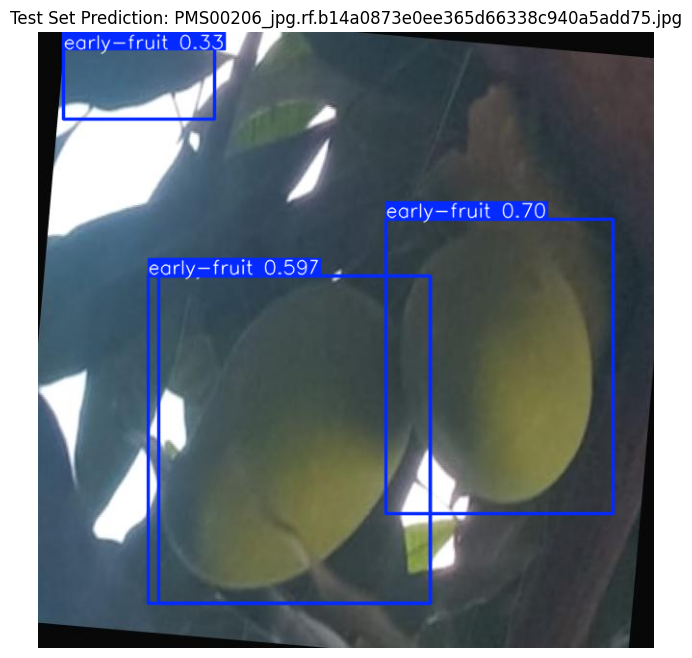

In [10]:
best_pt = WORK / "ssl_yolov10n_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

# Evaluate on TEST SET (not validation set)
# First, we need to create a temporary YAML file that points to the test set
test_yaml_path = WORK / "test_data.yaml"
with open(DATA, 'r') as f:
    config = yaml.safe_load(f)

# Modify config to point to test set for evaluation
test_config = config.copy()
test_config['val'] = 'test/images'  # Point validation to test set for evaluation

with open(test_yaml_path, 'w') as f:
    yaml.dump(test_config, f)

# Now evaluate on test set
print("Evaluating on TEST SET...")
results = model_det.val(data=str(test_yaml_path),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\n" + "="*50)
print("TEST SET EVALUATION METRICS")
print("="*50)
print(f" Precision (mP)     : {mp:.4f}")
print(f" Recall    (mR)     : {mr:.4f}")
print(f" F1-Score           : {2 * (mp * mr) / (mp + mr) if (mp + mr) > 0 else 0:.4f}")
print(f" mAP@0.50           : {map50:.4f}")
print(f" mAP@0.50-0.95      : {map5095:.4f}")
print("="*50)

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    print(f"\nVisualizing test image: {img_path.name}")
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.title(f"Test Set Prediction: {img_path.name}")
    plt.show()
else:
    print("No test images found for visualization.")


# PCA of SSL-pretrained YOLOv10 backbone features (robust encoder)

Evaluating on TEST SET...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,265,753 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 640.8±100.5 MB/s, size: 34.8 KB)
val: Scanning /kaggle/working/yolo_split/test/labels.cache... 149 images, 52 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 265195.1it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 29.0it/s 1.8s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201        223      0.764      0.691      0.839      0.719
           early-fruit        149        223      0.764      0.691      0.839      0.719
Speed: 0.7ms preprocess, 4.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2

TEST SET EVALUATION METRICS
 Precision (mP)     : 0.7639
 Recall    (mR)     : 0.6906
 F1-Score           : 0.7254
 mAP@0.50           : 0.8387
 mAP@0.50-0.95      : 0.7189

Visualizing test image: MS00256_jpg.rf.48315ec28fc9188d07058ba84707f3a0.jpg


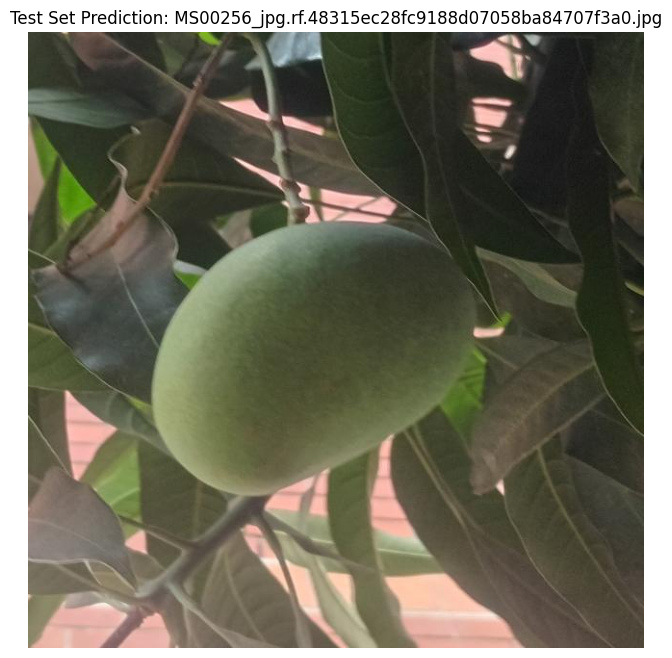

In [11]:
best_pt = WORK / "ssl_yolov10n_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

# Evaluate on TEST SET (not validation set)
# First, we need to create a temporary YAML file that points to the test set
test_yaml_path = WORK / "test_data.yaml"
with open(DATA, 'r') as f:
    config = yaml.safe_load(f)

# Modify config to point to test set for evaluation
test_config = config.copy()
test_config['val'] = 'test/images'  # Point validation to test set for evaluation

with open(test_yaml_path, 'w') as f:
    yaml.dump(test_config, f)

# Now evaluate on test set
print("Evaluating on TEST SET...")
results = model_det.val(data=str(test_yaml_path),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\n" + "="*50)
print("TEST SET EVALUATION METRICS")
print("="*50)
print(f" Precision (mP)     : {mp:.4f}")
print(f" Recall    (mR)     : {mr:.4f}")
print(f" F1-Score           : {2 * (mp * mr) / (mp + mr) if (mp + mr) > 0 else 0:.4f}")
print(f" mAP@0.50           : {map50:.4f}")
print(f" mAP@0.50-0.95      : {map5095:.4f}")
print("="*50)

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    print(f"\nVisualizing test image: {img_path.name}")
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.title(f"Test Set Prediction: {img_path.name}")
    plt.show()
else:
    print("No test images found for visualization.")
